<a id="section_top"></a>
# Trip Set Synthesis - with Diffused OD Locations in TAZ Areas

An approach eliminating zero-estimate origin/destination pairs *before* synthesizing trips.  
Given a typical trip table, this results in trip generation *speedups of at least 100 times*  
compared to the object oriented approach, and more than 10 times faster  
compared to carrying forward a complete trip matrix.

In this version, trip origins and destinations are no longer simply placed at the centroid  
of each TAZ. They are now placed statistically near TAZ centroids, but still within each TAZ.

## Code Structure
> ### [Specification](#section_s)
> ### [Parameters and Assertions](#section_paa)
> ### [Random Table Functions](#section_rtf)
> ### [Vectorized Functions](#section_vf)
> ### [Non-Zero OD Pair Functions](#section_sf)
> ### [Output Functions](#section_of)
> ### [Main Execution Flow](#section_mef)

<a id="section_s"></a>
#### [&#8681;](#section_paa)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_top)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
## Specification

In [581]:
# encoding: UTF-8

'''
Trip Set Synthesis
------------------

Poisson trip time assignment for transportation simulation.

Takes   trip table, profile and TAZ files. A trip table is in the form of an
-----   orig/dest matrix, which is a square matrix of esitmated trip counts
        between transportation analysis zone (TAZ) pairs. So each index is the
        list of TAZ identifiers for the particular municipal planning area.

Returns trip set csv file. Trips are drawn from a poisson distribution based
------- on trip rates derived from the trip table and profile. The first line
        contains labels: depart, origLon, origLat, destLon, destLat. All
        coordinates are in WGS84 standard decimal degrees. Each line is one trip.
        The trips are sorted chronologically by departure epoch time.

Originally written and tested using Python 3.9.6, on macOS 14.2.1
'''

__author__    = 'Rob Kempf'
__status__    = 'Development'
__version__   = '0.9.6'


In [582]:
'''
Definitions
-----------
Tripsets are built from trip tables. There may be different types of trip tables,
but the type used here estimates a trip count for a given time of day (ToD) period.

A trip table is actually a square matrix with indicies identified by TAZ areas
(Transportation Analysis Zones). The first dimension is by origin TAZ and
the second is the destination TAZ.

Values in these trip tables represent trip counts, that is, the number
of trips from one origin to one destination counted over the ToD period.
Our goal is to distribute synthesized trips over the the seconds in the
ToD period. The resultant synthesized trips combine to form a trip set.

'''
pass

In [583]:
'''
Toy Example
-----------
Let's assume we have trip tables for a toy municipal area with 10 TAZ areas.
Then let's say this trip table represents a daily period from 6am to 10am, perhaps
specifically on a Thursday. Here is how a simplified trip table might look:

               D E S T I N A T I O N
   TAZ  0   1   2   3   4   5   6   7   8   9
       --- --- --- --- --- --- --- --- --- ---
    0 | 43  40  18  27  98  51  18  92   4  78
    1 | 23   7  97  60  90  46  53  68  41  40
O   2 | 29  27  50  61  69   3  75  91  95  18
R   3 | 10  86  83  30  43  10  12  30  29  88
I   4 | 68  76  37  84  67  20  34  58  39  26
G   5 | 23  97  24  82  32  70  56  79  68  60
I   6 | 50  65  22  27  58  51  22  50  46  86
N   7 | 28  13   4  27  66  11  41  79  26  78
    8 | 94  53  71   2  62  49  49   7  85  90
    9 | 62  39  85  11   3  65  91  46  63  51

Again, the dimensions represent each TAZ area. The values are the estimated
trip counts over the ToD period (4 hours). So between 6am and 10am, the trip
count from TAZ #5 (origin) to TAZ #2 (destination) is expected to be 24 trips.

Take just this single example [5, 2] of 24 trips. Using a probability function,
we can assign trips for the given time of day period (from 6am to 10am)
by first splitting the ToD period into smaller time slots. The time slots are
typically sized to minutes, so in this case there are 240 time slots (4 hours).

So then we assume a Poisson distribution inside the ToD and generate a random
trip count for each time slot using the time slot trip rates.

Finally, we construct the trip set as a table of departure times, origins, and
destinations using the trip counts generated for each estimate period.

The code below generalizes this process in vectorized form.
'''
pass

In [584]:
import os
import sys
import time
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely.geometry as geo
import matplotlib.pyplot as plt
import shapely.speedups
shapely.speedups.enable()

<a id="section_paa"></a>
#### [&#8681;](#section_rtf)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_s)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
## Parameters and Assertions

In [585]:
''' Configuration Parameters '''

# test with random tables. False means load from files
testRandom          =      False
# test all day profile
testAllDay          =      True
# ship diffusion step
skipDiffusion       =      False
# choose normal or uniform diffusion of origins and destinations
normalDiffusion     =      False
# chose to save shape file
saveShapeFile       =      False

# set estimated trips
totalTripsInDay     =      3_820_000
# set daily split times
moringStart24Hour   =      6.5
middayStart24Hour   =      9.5
eveningStart24Hour  =      15.5
offPeakStart24Hour  =      18.5
# set off-peak half
offPeakAMorPM       =     'PM'
# set day of week
dayOfWeekString     =     'WEDNESDAY'
# set time zone
timeZoneOffsetHours =      -6 # CST (UTC-6 in January)
# set file directory
fileDir             =     'austin'
# set TAZ directory
tazDir              =     'campo'
# shape file directory
shapeFileDir        =     'shape'
# set TAZ centroid file
centroidFile        =     '2010_CAMPO_centroids.shp'
# set TAZ area file
tazAreaFile         =     '2010 Master TAZ.shp'
# set UTM zone
utmZone             =     'epsg:32614' # Austin, TX
# set OD diffusion factor
diffusionFactor     =      0.5 # higher means larger std dev
# set TAZ to plot
tazToPlot           =      697 # counting starts from 1, try 1326 or 697, both outside their TAZ
# set profile file
dailyProfileFile    =     'Seattle_traffic_profile.csv'
# set trip table file ...
tripTableFile       =     'Austin_trips_off_peak.csv'

In [586]:
''' File Parameters '''

# ... from file choices used to derive time of day
if tripTableFile    ==    'Austin_trips_morning.csv':
    timeOfDayString = 'morning'
if tripTableFile    ==    'Austin_trips_midday.csv':
    timeOfDayString = 'midday'
if tripTableFile    ==    'Austin_trips_evening.csv':
    timeOfDayString = 'evening'
if tripTableFile    ==    'Austin_trips_off_peak.csv':
    timeOfDayString = 'offPeak' + offPeakAMorPM
    
# use dynamic syntax to name trip set file
tripSetFileName     =     'trip_set_' + tripTableFile
if 'off' in tripTableFile:
    tripSetFileName = tripSetFileName[:-4] + '_' + offPeakAMorPM + '.csv'
    
if testAllDay and not testRandom:
    timeOfDayString = 'allDay'
    tripSetFileName = 'trip_set_test_all_day.csv'
    print('\ntest all day profile with trip table   ...  ', end='')
    print(tripTableFile)
    print('saving output to file named            ...  ', end='')
    print(tripSetFileName)


test all day profile with trip table   ...  Austin_trips_off_peak.csv
saving output to file named            ...  trip_set_test_all_day.csv


In [587]:
''' Time Parameters '''

secPerSlot   = 60     # seconds per profile time slot (usually 60)

# epoch seconds position day of week and time of day as int32 seconds
SEC_PER_HOUR = 3600
SEC_PER_DAY  = 24 * SEC_PER_HOUR
TIME_ZONE_OFFSET_SEC = SEC_PER_HOUR * timeZoneOffsetHours
# time basis is Monday, January 5, 1970 12:00:00 AM (epoch 345600)
FIRST_MONDAY = 345600
MONDAY    = FIRST_MONDAY - TIME_ZONE_OFFSET_SEC
TUESDAY   = MONDAY    + SEC_PER_DAY
WEDNESDAY = TUESDAY   + SEC_PER_DAY
THURSDAY  = WEDNESDAY + SEC_PER_DAY
FRIDAY    = THURSDAY  + SEC_PER_DAY
SATURDAY  = FRIDAY    + SEC_PER_DAY
SUNDAY    = SATURDAY  + SEC_PER_DAY
dayOfWeek = eval(dayOfWeekString)

# time of day list for scaling rates
timeOfDayList = [\
int(moringStart24Hour  * SEC_PER_HOUR / secPerSlot),\
int(middayStart24Hour  * SEC_PER_HOUR / secPerSlot),\
int(eveningStart24Hour * SEC_PER_HOUR / secPerSlot),\
int(offPeakStart24Hour * SEC_PER_HOUR / secPerSlot)]

# derived time parameters
morningStartSec = dayOfWeek + (moringStart24Hour  * SEC_PER_HOUR)
middayStartSec  = dayOfWeek + (middayStart24Hour  * SEC_PER_HOUR)
eveningStartSec = dayOfWeek + (eveningStart24Hour * SEC_PER_HOUR)
offPeakStartSec = dayOfWeek + (offPeakStart24Hour * SEC_PER_HOUR)
offPeakAM  = (    dayOfWeek,        int(morningStartSec))
morning    = (int(morningStartSec), int(middayStartSec))
midday     = (int(middayStartSec),  int(eveningStartSec))
evening    = (int(eveningStartSec), int(offPeakStartSec))
offPeakPM  = (int(offPeakStartSec), dayOfWeek + SEC_PER_DAY)
allDay     = (    dayOfWeek,        dayOfWeek + SEC_PER_DAY)

timeOfDay  = eval(timeOfDayString)
startEpoch = timeOfDay[0]
diffusionRunTime = 0

print('dayOfWeek:\t', time.strftime('%A', time.localtime(dayOfWeek)))
print('timeOfDayString:', timeOfDayString)
print('startEpoch:\t', startEpoch)
print('timeOfDayList:')
print(timeOfDayList)

dayOfWeek:	 Wednesday
timeOfDayString: allDay
startEpoch:	 540000
timeOfDayList:
[390, 570, 930, 1110]


In [588]:
''' Random Run Config Parameters '''

# trip table parameters for random run
numTAZ     = 100   # number of transportation analysis zones
tripStdDev = 200   # standard deviation of trips from zero

# trip count parameters for random run
numSlots   = 120   # time slots for trips in orig/dest matrix period (usually minutes)

# parabolic trip rate profile parameters (for uniform profile, set aParabolic = 0)
aParabolic = 1.0  # - is a max, + is a min, smaller abs values flatten curvature
hParabolic = 0.2  # shifts profile parabola by time across time slots

# random TAZ geo parameters (sets bounding box)
minLon, maxLon, minLat, maxLat = (-98.5, -97.0, 29.5, 31.0)

In [589]:
''' Random Run Time Parameters '''

if testRandom:
    timeOfDayString = 'random'
    tripSetFileName = 'trip_set_random.csv'
    dayOfWeekString = 'THURSDAY'
    randomStart     =  21600   # 6:00:00 AM Thursday, January 1, 1970 GMT
    timeOfDay       = (randomStart, randomStart + (numSlots * secPerSlot))
    dayOfWeek       = randomStart - TIME_ZONE_OFFSET_SEC
    startEpoch      = timeOfDay[0]
    print('for random run:')
    print('dayOfWeek:\t', time.strftime('%A', time.localtime(dayOfWeek)))
    print('timeOfDayString:', timeOfDayString)
    print('startEpoch:\t', startEpoch)

In [590]:
''' Memory Footprint Parameters '''

# integer type sized to control memory footprint
intBytes   = 2
intType    = 'i' + str(intBytes)
maxInt     = 2**(8*intBytes-1) - 1

In [591]:
''' Code Safety Assertions '''

assert(1 <= numTAZ     <= maxInt)
assert(1 <= numSlots   <= maxInt)
assert(1 <= secPerSlot <= maxInt)
assert(1 <= 6.1 * tripStdDev <= maxInt) # 1e-9 chance of exceeding bounds
assert(0 <= startEpoch <= 2**31 - 1)    # epoch is int32 and must be >= 0

<a id="section_rtf"></a>
#### [&#8681;](#section_vf)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_paa)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
## Random Table Functions

*Functions used to test vectorized functions without needing to load trip files.*

In [592]:
def createRandomTripTable(numTAZ, tripStdDev):
    ''' Without a trip table to load, create one with random trip counts '''
    tripTable = np.random.normal(scale=tripStdDev, size=(numTAZ,numTAZ)).astype(intType)
    tripTable[tripTable < 0] = 0 # no negative trips (about half go to zero)
    print('\nCreated tripTable with specified trip counts ('+str(numTAZ)+' X '+str(numTAZ)+'):')
    print(tripTable)
    print('\ntripTable dtype:', tripTable.dtype)
    print('Number of TAZs :', numTAZ)
    print('Pair trip stdDev:', tripStdDev)
    print('Total TAZ pairs:', '{:,}'.format(tripTable.size))
    print('time of day period:', timeOfDayString)
    percentNonZeroElements = 100 * (np.sum(tripTable > 0) / tripTable.size)
    print('Non-zero elements:', '{:.2f}'.format(percentNonZeroElements), '%')
    print('Total trips in tripTable:', '{:,}'.format(np.sum(tripTable)))
    return tripTable, numTAZ 

In [593]:
def createParabolicProfile(numSlots, a, h):
    ''' Construct parabolic profile factors and plot profile.
        The idea is to use a function to shape trip rates across time slots
        by building a profile vector holding a rate factor for each time slot.
        Use parabolic function -> profile = a(t – h)^2 + k
        where a = flatness, h = vertex, and k = 1 - a(h^2 -h + 1/3) from 0 to 1
        CAUTION   both "a" and "h" must be in range for the parabola
                  to span 0 <= t <= 1 such that profile >= 0 '''
    k = 1 - a*(h**2 -h + 1/3) # 0 to 1 def integral of parabola, for k with area=1
    t = np.arange(numSlots+1)[1:]/numSlots # t array = 1/numSlots to 1
    profile = a*(t-h)**2 + k # parabolic profile
    # report profile function parameters
    print('\nProfile attributes:')
    print('Parabolic curvature coefficient    :', '{:5.3f}'.format(a))
    print('Horizontal translation of parabola :', '{:5.3f}'.format(h))
    print('Vertical translation of parabola   :', '{:5.3f}'.format(k))
    return profile, numSlots

In [594]:
def createRandomTazTable(numTAZ, minLon, maxLon, minLat, maxLat):
    ''' Build table of random lon/lats to translate from TAZ indexes '''
    lonRange = maxLon - minLon
    latRange = maxLat - minLat
    tazTable = np.zeros((numTAZ, 2), dtype='f4')
    tazTable[:,0] = np.random.random(size=numTAZ) * lonRange + minLon # longitudes
    tazTable[:,1] = np.random.random(size=numTAZ) * latRange + minLat # latitudes
    print(tazTable[:10,:])
    print('\nTAZ lon/lat table shape:', tazTable.shape, ' ')
    return tazTable

<a id="section_vf"></a>
#### [&#8681;](#section_sf)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_rtf)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
## Vectorized Functions

*Main functions used to transform trip files to a trip set.*

In [595]:
def loadTripTable(dirName, fileName, timeOfDayString, offPeakAM, offPeakPM):
    ''' load trip table matrix from file '''
    filePath = os.path.join(dirName, fileName)
    print('trip table matrix file path:', filePath)
    tripTable = pd.read_csv(filePath)
    tripTable = tripTable.iloc[1:,2:] # removes integer headers from original file
    tripTable = tripTable.as_matrix() # convert from pandas to numpy for interim processing
    if 'off' in timeOfDayString:
        tripTable = splitOffPeak(tripTable, timeOfDayString, offPeakAM, offPeakPM)
    assert(np.all(np.amin(tripTable) >= 0)) # all tripTable values > = 0
    assert(tripTable[0,:].size == tripTable[:,0].size) # is square
    numTAZ = tripTable[0,:].size
    print('\nLoaded tripTable with specified trip counts ('+str(numTAZ)+' X '+str(numTAZ)+'):')
    print(tripTable)
    print('\ntripTable dtype:', tripTable.dtype)
    print('Total TAZ pairs:', '{:,}'.format(tripTable.size))
    print('time of day period:', timeOfDayString)
    percentNonZeroElements = 100 * (np.sum(tripTable > 0) / tripTable.size)
    print('Non-zero elements :', '{:.2f}'.format(percentNonZeroElements), '%')
    print('Total trips in tripTable:', '{:,}'.format(int(np.sum(tripTable))))
    return tripTable, numTAZ

In [596]:
def splitOffPeak(tripTable, timeOfDayString, offPeakAM, offPeakPM):
    ''' off-peak trip table ranges across two separate periods. Split it. '''
    amLength = offPeakAM[1] - offPeakAM[0]
    pmLength = offPeakPM[1] - offPeakPM[0]
    amSplitRatio = amLength / (amLength + pmLength)
    if 'AM' in timeOfDayString:
        tripTable = tripTable * amSplitRatio       # AM
    else:
        tripTable = tripTable * (1 - amSplitRatio) # PM
    return tripTable # as doubles with fractional trips

In [597]:
def loadDayProfile(dirName, fileName, dayOfWeek, timeOfDay, secPerSlot):
    ''' load time of day profile from file '''
    filePath = os.path.join(dirName, fileName)
    print('Traffic profile file path:', filePath)
    profile = pd.read_csv(filePath)
    profile = profile.iloc[:,2]   # selects profile column from original file
    profile = profile.as_matrix() # convert from pandas to numpy for interim processing
    assert(np.all(np.amin(profile) >= 0)) # all profile values > = 0
    profile = (profile / profile.sum()) * profile.size  # normalize over all values
    dayProfile = np.copy(profile) # retain copy
    print('\nLoaded day profile size:', profile.size)
    print(profile[:8])    
    # now select profile rates for this period and normalize values
    begin = (timeOfDay[0] - dayOfWeek) // secPerSlot # seconds to period in day
    end   = (timeOfDay[1] - dayOfWeek) // secPerSlot
    profile = profile[begin:end] # subset slice
    numSlots = profile.size
    profile = (profile / profile.sum()) * numSlots # profile now a proportion of ToD period
    print('\nTime of day profile:', numSlots)
    print(profile[:8])
    print('\nprofile dtype:', profile.dtype)
    return profile, numSlots, dayProfile

In [598]:
def calculateRateTable(tripTable, numSlots):
    ''' Build the associated rate space with trip rates per time slot '''
    rateTable = tripTable / numSlots # trip rates scaled to time slot length
    print('Calculated rateTable of trip rates per time slot:\n')
    np.set_printoptions(precision=3)
    print(rateTable)
    print('\nrateTable dtype:', rateTable.dtype)
    print('Number of TAZ zones :', rateTable[:,0].size)
    print('Number of time slots:', numSlots)
    return rateTable

In [599]:
def getScaleFactor(rateTable, tripTable, dayProfile, totalTripsInDay, timeOfDayList, timeOfDayString):
    ''' trip rates scaled proportionally to total trips per day from daily profile '''
    print('Assumes day profile has 1440 one minute time slots.')
    print('This daylong profile size is:', dayProfile.size)
    if dayProfile.size != 1440:
        print('\n*** error: daylong profile length not 1440 minutes. ***\n')
        exit()
    trafficPeriod = {
        'offPeakAM': (0, timeOfDayList[0]),
        'morning'  : (timeOfDayList[0], timeOfDayList[1]),
        'midday'   : (timeOfDayList[1], timeOfDayList[2]),
        'evening'  : (timeOfDayList[2], timeOfDayList[3]),
        'offPeakPM': (timeOfDayList[3], dayProfile.size),
        'allDay'   : (0, 1440)
    }
    
    tod = trafficPeriod[timeOfDayString] # tuple of start and end minutes
    todProfileSubset = dayProfile[tod[0]:tod[1]]
    portion = todProfileSubset.sum() / dayProfile.sum()
    print('timeOfDayString:', timeOfDayString, tod)
    print('portion of daily trip target for this time of day period :', '{:5.2f}'.format(portion * 100), '%')
    print('total trips in the trip table for this time of day period:', '{:,}'.format(int(tripTable.sum())))
    print('target total trips for day:', '{:,}'.format(totalTripsInDay))
    
    dirName  = 'austin'
    fileList = ['Austin_trips_morning.csv', 'Austin_trips_midday.csv', \
                'Austin_trips_evening.csv', 'Austin_trips_off_peak.csv']
    TotalTripsInTables = 0
    for fileName in fileList:
        sumOfTripTable = loadTableSize(dirName, fileName)
        TotalTripsInTables += sumOfTripTable
    print('Total trips across all trip tables:', '{:,}'.format(TotalTripsInTables))
    currentShare = tripTable.sum() / TotalTripsInTables
    scaleFactor  = (portion / currentShare) * (totalTripsInDay / TotalTripsInTables)
    return scaleFactor

In [600]:
def loadTableSize(dirName, fileName):
    ''' load trip table matrix from file '''
    filePath = os.path.join(dirName, fileName)
    print('trip table matrix file path:', filePath)
    tripTable = pd.read_csv(filePath)
    tripTable = tripTable.iloc[1:,2:] # removes integer headers from original file
    tripTable = tripTable.as_matrix() # convert from pandas to numpy for interim processing
    assert(np.all(np.amin(tripTable) >= 0)) # all tripTable values > = 0
    assert(tripTable[0,:].size == tripTable[:,0].size) # is square
    return int(tripTable.sum())

In [601]:
def loadCentroidTazTable(numTAZ, tazDir, centroidFile, tazAreaFile):
    ''' Load centroid  TAZ table from shape file for lon/lats to translate from TAZ indexes '''
    print('numTAZ:', numTAZ)
    tazTable = np.zeros((numTAZ, 2))
    
    # first load TAZ centroids to build tazTable
    filePath = os.path.join(tazDir, centroidFile)
    centroidGdf = gpd.read_file(filePath)    
    centroidGdf = centroidGdf[['TAZ', 'geometry']] # trim table
    centroidGdf.sort_values(by='TAZ', inplace=True)
    centroidGdf = centroidGdf.reset_index(drop=True)
    if centroidGdf.shape[0] < numTAZ:
        print('error occured. TAZ count in shape file does not match number of TAZs in trip tables')
        return tazTable
    centroidGdf = centroidGdf.head(numTAZ) # trim TAZs beyond the number in the trip tables
    print('\n', centroidGdf.head(5))
    tazTable[:,0] = centroidGdf.geometry.map(lambda p: p.x)
    tazTable[:,1] = centroidGdf.geometry.map(lambda p: p.y)
    
    # now load TAZ area data
    filePath = os.path.join(tazDir, tazAreaFile)
    tazAreaGdf = gpd.read_file(filePath)
    tazAreaGdf = tazAreaGdf[['TAZ', 'AREA', 'geometry']] # trim table
    tazAreaGdf.sort_values(by='TAZ', inplace=True)
    tazAreaGdf = tazAreaGdf.reset_index(drop=True)
    if tazAreaGdf.shape[0] < numTAZ:
        print('error occured. TAZ count in shape file does not match number of TAZs in trip tables')
        return tazTable
    tazAreaGdf = tazAreaGdf.head(numTAZ) # trim TAZs beyond the number in the trip tables
    print('\n', tazAreaGdf.head(5))

    print('\nTAZ lon/lat table shape:', tazTable.shape, ' ')
    print(tazTable[:5,:])
    return tazTable, centroidGdf, tazAreaGdf

In [602]:
def buildTripSet(countTable, secPerSlot):
    print('Building tripSet ...'); startTime = time.time()
    numSyntheticTrips = np.sum(countTable[:,3])
    tripSet = pd.DataFrame(np.zeros( (numSyntheticTrips,), \
    dtype=[('depart','i4'),('origLon','f4'),('origLat','f4'),('destLon','f4'),('destLat','f4')]))
    print('tripSet shape:', tripSet.shape)
    print('tripSet depart series dtype:', tripSet.depart.dtype)
    print('tripSet lon/lat series dtype:', tripSet.origLon.dtype)
    print('tripSet memory footprint in bytes:', '{:,}'.format(4 * tripSet.size))
    print('Seconds to build tripSet:', '{:5.2f}'.format(time.time()-startTime))
    return tripSet

In [603]:
def MonteCarloTime(tripSet, secPerSlot, startEpoch):
    ''' spread trips randomly over seconds in each time slot '''
    tripSet.depart *= secPerSlot # converts timeSlots to seconds
    tripSet.depart += startEpoch # time now in epoch seconds
    tripSet.depart += np.random.randint(0, secPerSlot, (tripSet.depart.shape))
    return tripSet

![title](img/trip_space.png)

In [604]:
def buildCountTable(numTAZ, numSlots, intType, intBytes): # superseded by buildNzPairCountTable
    ''' Allocate countTable as [timeSlot,orig,dest,count], where count
        is the number of trips in that timeSlot from orig to dest.
        Alloacte the full table first, then fill in the first three columns.
        The last column (count) will be filled in when trips are synthesized '''
    print('\ncountTable RAM:')
    print('countTable maxInt:', 2**(8*intBytes-1) - 1)
    countTableColumns = 4
    footprint = countTableColumns * numSlots * numTAZ**2 * intBytes
    print('synthesized countTable memory footprint in bytes:', '{:,}'.format(footprint))
    print('\nBuilding countTable ...'); startTime = time.time()
    numCounts  = numSlots * numTAZ**2 # one for every timeSlot and TAZ orig/dest
    countTable = np.zeros((numCounts, countTableColumns), dtype=intType) # [timeSlot,orig,dest,count]
    countTable[:,0] = np.repeat(np.arange(numSlots), numTAZ**2) # timeSlot
    countTable[:,1] = np.tile(np.repeat(np.arange(numTAZ), numTAZ), numSlots) # origin
    countTable[:,2] = np.tile(np.arange(numTAZ), numTAZ * numSlots) # destination
    print('Total rows in countTable:', '{:,}'.format(countTable.shape[0]))
    print('Total bytes used by countTable:', '{:,}'.format(intBytes * countTable.size))
    print('Seconds to build countTable:', '{:5.2f}'.format(time.time()-startTime))
    return countTable

In [605]:
def synthesizeTrips(tripTable, rateTable, profile, countTable): # superseded by synthesizeNzPairTrips
    ''' Synthesize all trips with profile rates across all time slots.
        Synthesized trips are arranged by (timeSlot, origTAZ, destTAZ)
        and then raveled into one column in countTable[:,3].
        When sparse, trips are instead arranged by (timeSlot, nzOdPair).
        Uses the same profile factors across all TAZ pairs '''
    print('\nSynthesizing trips ...'); startTime = time.time()
    # match array dimensions for elementwise multiplication
    rateTable = rateTable[tripTable > 0].ravel() # only non-zeros
    profile   = profile[:,None]
    rateTable = rateTable[None,:]
    print('profile.shape:', profile.shape)
    print('rateTable.shape:', rateTable.shape)
    # synthesize trips by random draw from poisson distribution with given rates
    trips = np.random.poisson(profile * rateTable)
    print('poisson trips shape:', trips.shape)
    countTable[:,3] = trips.ravel() # flattten trips by reference into countTable
    print('Total synthesized trips across all TAZ pairs:', '{:,}'.format(np.sum(countTable[:,3])))
    print('Compare to tripTable total projected trips  :', '{:,}'.format(int(np.sum(tripTable))))
    print('Seconds to synthesize trips:', '{:5.2f}'.format(time.time()-startTime))
    print('\nFilled countTable:')
    print(countTable)
    return countTable

In [606]:
def fillTripSet(countTable, tripSet, tazTable, secPerSlot, startEpoch): # superseded by fillNzPairTripSet
    ''' Slice countTable and copy slices of individual trips to tripSet '''
    print('\nFilling tripSet ...'); startTime = time.time()
    firstRow  = 0 # index of next available tripSet row for copy
    threshold = 0 # threshold number of trips for picking from countTable
    remainingTrips = countTable[:,3] > threshold # trips left to count
    while np.any(remainingTrips): # while there are still trips to count
        tripCount  = np.sum(countTable[remainingTrips,3]) # remaining trips
        lastRow = firstRow + np.sum(remainingTrips)
        tripSet.iloc[firstRow:lastRow,0] = countTable[remainingTrips,0].copy() # timeSlots
        tripSet.iloc[firstRow:lastRow,1] = tazTable[countTable[remainingTrips,1],0].copy() # origLon
        tripSet.iloc[firstRow:lastRow,2] = tazTable[countTable[remainingTrips,1],1].copy() # origLat
        tripSet.iloc[firstRow:lastRow,3] = tazTable[countTable[remainingTrips,2],0].copy() # destLon
        tripSet.iloc[firstRow:lastRow,4] = tazTable[countTable[remainingTrips,2],1].copy() # destLat
        print('trip rows =', '{:,}'.format(np.sum(remainingTrips)), end='')
        print(' with num trips =', '{:,}'.format(np.sum(countTable[remainingTrips,3])))
        firstRow = lastRow
        threshold += 1
        remainingTrips = countTable[:,3] > threshold
    tripSet = MonteCarloTime(tripSet, secPerSlot, startEpoch)
    tripSet.sort_values('depart',  inplace=True) # sort tripSet by time
    tripSet.reset_index(drop=True, inplace=True)
    print('Seconds to fill tripSet:', '{:5.2f}'.format(time.time()-startTime))
    print('\n              - Completed tripSet -')
    print(tripSet.head())
    print('...')
    print(tripSet.tail(), '\n')
    return tripSet

<a id="section_sf"></a>
#### [&#8681;](#section_of)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_vf)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
## Non-Zero OD Pair Functions

*Functions optimized for execution on sparse trip tables. Now used for all trip tables for highest performance.*

<img src="img/non-zero_synth_space.png" width="75%">

In [607]:
def buildNzPairCountTable(tripTable, numTAZ, numSlots, intType, intBytes):
    
    ''' Allocate countTable as [timeSlot,orig,dest,count], where count
        is the number of trips in that timeSlot from orig to dest.
        Only alloacte space for non-zero counts, then fill in the first three columns.
        The last column (count) will be filled in when trips are synthesized '''
    print('sparse countTable RAM:')
    print('sparse countTable maxInt:', 2**(8*intBytes-1) - 1)
    countTableColumns = 4
    nonZeroCount = np.sum     (tripTable > 0)
    nzOdPair     = np.argwhere(tripTable > 0)
    footprint = countTableColumns * numSlots * nonZeroCount * intBytes
    print('number of orig/dest pairs with non-zero trip counts:', '{:,}'.format(nonZeroCount))
    print('synthesized sparse countTable memory footprint in bytes:', '{:,}'.format(footprint))
    print('\nBuilding Sparse countTable ...'); startTime = time.time()
    countTable = np.zeros((numSlots * nonZeroCount, countTableColumns), dtype=intType) # [timeSlot,orig,dest,count]    
    countTable[:,0] = np.repeat(np.arange(numSlots), nonZeroCount) # timeSlot
    countTable[:,1] = np.tile(nzOdPair[:,0], numSlots) # origin
    countTable[:,2] = np.tile(nzOdPair[:,1], numSlots) # destination
    print(countTable)
    print('\nTotal rows in countTable:', '{:,}'.format(countTable.shape[0]))
    print('Total bytes used by countTable:', '{:,}'.format(intBytes * countTable.size))
    print('Seconds to build countTable:', '{:5.2f}'.format(time.time()-startTime))
    return countTable

In [608]:
def synthesizeNzPairTrips(tripTable, rateTable, profile, countTable):
    ''' Synthesize all trips with profile rates across all time slots.
        Synthesized trips are arranged by (timeSlot, nzOdPair)
        and then raveled into one column in countTable[:,3].
        Uses the same profile factors across all TAZ pairs '''
    print('Synthesizing trips ...'); startTime = time.time()
    nzOdPair  = np.argwhere(tripTable > 0)
    rateTable = rateTable[nzOdPair[:,0], nzOdPair[:,1]]
    # match array dimensions for elementwise multiplication
    profile = profile[:,None]
    print('profile.shape:', profile.shape)
    rateTable = rateTable[None,:]
    print('rateTable.shape:', rateTable.shape)
    # synthesize trips by random draw from poisson distribution with given rates
    trips = np.random.poisson(profile * rateTable)
    print('poisson trips shape:', trips.shape)
    countTable[:,3] = trips.ravel() # flattten trips by reference into countTable
    print('Total synthesized trips across all TAZ pairs:', '{:,}'.format(np.sum(countTable[:,3])))
    print('Compare to tripTable total projected trips  :', '{:,}'.format(int(np.sum(tripTable))))
    print('Seconds to synthesize trips:', '{:5.2f}'.format(time.time()-startTime))
    return countTable

In [609]:
def fillNzPairTripSet(countTable, tripSet, tazTable, secPerSlot, startEpoch):
    ''' Slice countTable and copy slices of individual trips to tripSet '''
    print('Filling tripSet ...'); startTime = time.time()
    numTAZ = tazTable[:,0].size
    print('numTAZ:', numTAZ)
    firstRow  = 0 # index of next available tripSet row for copy
    threshold = 0 # threshold number of trips for picking from countTable
    remainingTrips = countTable[:,3] > threshold # trips left to count
    while np.any(remainingTrips): # while there are still trips to count
        tripCount  = np.sum(countTable[remainingTrips,3] - threshold) # remaining trips
        lastRow = firstRow + np.sum(remainingTrips)
        tripSet.iloc[firstRow:lastRow,0] = countTable[remainingTrips,0].copy() # timeSlots
        tripSet.iloc[firstRow:lastRow,1] = tazTable[countTable[remainingTrips, 1],0].copy()# origLon
        tripSet.iloc[firstRow:lastRow,2] = tazTable[countTable[remainingTrips,1],1].copy() # origLat
        tripSet.iloc[firstRow:lastRow,3] = tazTable[countTable[remainingTrips,2],0].copy() # destLon
        tripSet.iloc[firstRow:lastRow,4] = tazTable[countTable[remainingTrips,2],1].copy() # destLat
        tripRows = np.sum(remainingTrips)
        print('trip rows =', '{:,}'.format(tripRows), end='')
        print(' with num trips =', '{:,}'.format(tripCount))
        firstRow = lastRow
        threshold += 1
        remainingTrips = countTable[:,3] > threshold
        #print('threshold', threshold, 'firstRow:',firstRow, 'tripRows', tripRows, 'tripCount', tripCount)
    tripSet = MonteCarloTime(tripSet, secPerSlot, startEpoch)
    tripSet.sort_values('depart',  inplace=True) # sort tripSet by time
    tripSet.reset_index(drop=True, inplace=True)
    print('Seconds to fill tripSet:', '{:5.2f}'.format(time.time()-startTime))
    print('\n              - Completed tripSet -')
    print(tripSet.head())
    print('...')
    print(tripSet.tail(), '\n')
    return tripSet

In [610]:
def fillDiffusedTripSet(centroidGdf, tazAreaGdf, countTable, tripSet, \
                        tazTable, secPerSlot, startEpoch, diffusionFactor, normalDiffusion):
    ''' Slice countTable and copy slices of individual trips to tripSet.
        Spread origins and destinations randomly in each TAZ. '''
    print('Filling tripSet ...'); startTime = time.time()
    if normalDiffusion:
        print('Diffusion is done with a Normal distribution.')
    else:
        print('Diffusion is done with a Uniform distribution.')
    numTAZ = tazTable[:,0].size
    print('numTAZ:', numTAZ)
    firstRow  = 0 # index of next available tripSet row for copy
    threshold = 0 # threshold number of trips for picking from countTable
    remainingTrips = countTable[:,3] > threshold # trips left to count
    centroidGdf, tazAreaGdf, centroidTable = diffusionPrep(centroidGdf, tazAreaGdf)
    while np.any(remainingTrips): # while there are still trips to count
        # ---------------- this is the main change from fillNzPairTripSet -----------------
        if normalDiffusion: # normal diffusion
            print()
            diffusedOrigTazTable = diffuseLocationsNormal(centroidTable, centroidGdf, \
                                                tazAreaGdf, numTAZ, diffusionFactor) # new set of origins
            print()
            diffusedDestTazTable = diffuseLocationsNormal(centroidTable, centroidGdf, \
                                                tazAreaGdf, numTAZ, diffusionFactor) # new set of destinations
            print()
        else:              # uniform diffusion
            print()
            diffusedOrigTazTable = diffuseLocationsUniform(centroidTable, centroidGdf, \
                                                                 tazAreaGdf, numTAZ) # new set of origins
            print()
            diffusedDestTazTable = diffuseLocationsUniform(centroidTable, centroidGdf, \
                                                                 tazAreaGdf, numTAZ) # new set of destinations
            print()
        # ---------------------------------------------------------------------------------
        tripCount  = np.sum(countTable[remainingTrips,3] - threshold) # remaining trips
        lastRow = firstRow + np.sum(remainingTrips)
        tripSet.iloc[firstRow:lastRow,0] = countTable[remainingTrips,0].copy() # timeSlots
        tripSet.iloc[firstRow:lastRow,1] = diffusedOrigTazTable[countTable[remainingTrips, 1],0].copy()# origLon
        tripSet.iloc[firstRow:lastRow,2] = diffusedOrigTazTable[countTable[remainingTrips,1],1].copy() # origLat
        tripSet.iloc[firstRow:lastRow,3] = diffusedDestTazTable[countTable[remainingTrips,2],0].copy() # destLon
        tripSet.iloc[firstRow:lastRow,4] = diffusedDestTazTable[countTable[remainingTrips,2],1].copy() # destLat
        tripRows = np.sum(remainingTrips)
        print('trip rows =', '{:,}'.format(tripRows), end='')
        print(' with num trips =', '{:,}'.format(tripCount))
        firstRow = lastRow
        threshold += 1
        remainingTrips = countTable[:,3] > threshold
        #print('threshold', threshold, 'firstRow:',firstRow, 'tripRows', tripRows, 'tripCount', tripCount)
    tripSet = MonteCarloTime(tripSet, secPerSlot, startEpoch)
    tripSet.sort_values('depart',  inplace=True) # sort tripSet by time
    tripSet.reset_index(drop=True, inplace=True)
    diffusionRunTime = time.time()-startTime
    print('Seconds to fill tripSet:', '{:5.2f}'.format(time.time()-startTime))
    print('\n              - Completed tripSet -')
    print(tripSet.head())
    print('...')
    print(tripSet.tail(), '\n')
    return tripSet, diffusionRunTime

In [611]:
def diffuseLocationsNormal(centroidTable, centroidGdf, tazAreaGdf, numTAZ, diffusionFactor):
    ''' Change origns and destinations from centroids to heterogeneous locations.
    Consider non-centroid locations to be normally distributed about TAZ centroids,
    but still within the TAZ area. Use TAZ size to estimate the standard deviation.'''    
    # approximate TAZ areas as circles, then find radii
    radius = np.sqrt(tazAreaGdf.geometry.area / np.pi) # r =sqrt(Area/pi), where Area of circle = TAZ area
    radius = radius[:,None] # to match dimensions of other arrays below
    indexNotInTaz = range(numTAZ) # begin with Python list of all indices as not in TAZ
    diffusedTable = np.zeros((numTAZ, 2))
    while len(indexNotInTaz) != 0:        
        # set standard deviation to half of radius, find normal ditribution with 95% in area circle
        i = indexNotInTaz
        diffusedTable[i,0] = centroidTable[i,0] + np.random.normal(scale=radius[i,0]*diffusionFactor) # run random normal separately
        diffusedTable[i,1] = centroidTable[i,1] + np.random.normal(scale=radius[i,0]*diffusionFactor) # for each coordinate series   
        
        # put diffused table into a GeoDataFrame to test against TAZ area GeoDataFrame
        geometry = [geo.Point(xy) for xy in zip(diffusedTable[:,0], diffusedTable[:,1])]
        df = pd.DataFrame(np.arange(numTAZ) + 1, columns=['TAZ']) # same TAZ numbers as centroidGdf
        diffusedGdf = gpd.GeoDataFrame(df, geometry=geometry)
        diffusedGdf.crs = {'init': utmZone}

        # test if diffused points are inside TAZ
        isInTaz = diffusedGdf.within(tazAreaGdf)
        indexNotInTaz = np.argwhere(np.logical_not(isInTaz)).tolist()
        print(np.sum(isInTaz), 'of', isInTaz.size, 'within TAZ')
    
    # put diffused points back in numpy table
    diffusedGdf = diffusedGdf.to_crs({'init': 'epsg:4326'}) # back to lon/lat
    diffusedTable[:,0] = diffusedGdf.geometry.map(lambda p: p.x)
    diffusedTable[:,1] = diffusedGdf.geometry.map(lambda p: p.y)
    return diffusedTable

In [612]:
def diffuseLocationsUniform(centroidTable, centroidGdf, tazAreaGdf, numTAZ):
    ''' Change origns and destinations from centroids to heterogeneous locations.
    Consider non-centroid locations to be uniformly distributed within TAZ areas '''
    diffusedTable = np.zeros((numTAZ, 2))
    indexNotInTaz = np.full((numTAZ), True) # begin with array indicating all indices not in TAZ
    while np.any(indexNotInTaz):
        i = indexNotInTaz
        b = tazAreaGdf.bounds # a pandas DataFrame
        # slice arrays so as to only draw random values on the indices required
        diffusedTable[i,0] = np.random.uniform(b.minx[i], b.maxx[i]) # run random uniform separately
        diffusedTable[i,1] = np.random.uniform(b.miny[i], b.maxy[i]) # for each coordinate series   
        
        # put diffused table into a GeoDataFrame to test against TAZ area GeoDataFrame
        geometry = [geo.Point(xy) for xy in zip(diffusedTable[:,0], diffusedTable[:,1])]
        df = pd.DataFrame(np.arange(numTAZ)+1, columns=['TAZ'])   # same TAZ numbers as centroidGdf
        diffusedGdf = gpd.GeoDataFrame(df, geometry=geometry)
        diffusedGdf.crs = {'init': utmZone}
        
        # test if diffused points are inside TAZ areas
        isInTaz = diffusedGdf.within(tazAreaGdf)
        
        indexNotInTaz = np.logical_not(isInTaz)
        print(np.sum(isInTaz), 'of', isInTaz.size, 'within TAZ')
    # put diffused points back in numpy table
    diffusedGdf = diffusedGdf.to_crs({'init': 'epsg:4326'})        # back to lon/lat
    diffusedTable[:,0] = diffusedGdf.geometry.map(lambda p: p.x)
    diffusedTable[:,1] = diffusedGdf.geometry.map(lambda p: p.y)
    return diffusedTable

In [613]:
def diffusionPrep(centroidGdf, tazAreaGdf):
    # convert from WGS84 (i.e. EPSG: 4326) to utmZone for meters
    # first for centroid GeoDataFrame
    centroidGdf.crs = {'init': 'epsg:4326'}
    centroidGdf = centroidGdf.to_crs({'init': utmZone})
    # and then for TAZ area GeoDataFrame
    tazAreaGdf.crs = {'init': 'epsg:4326'}
    tazAreaGdf = tazAreaGdf.to_crs({'init': utmZone})
    # build centroid table from UTM meters in GeoDataFrame
    centroidTable = np.zeros((numTAZ, 2))
    centroidTable[:,0] = centroidGdf.geometry.map(lambda p: p.x)
    centroidTable[:,1] = centroidGdf.geometry.map(lambda p: p.y)
    # test if centroid points land inside assigned TAZ
    isInTaz = centroidGdf.within(tazAreaGdf)
    print('number of centroids that fall within their TAZ polygons:', np.sum(isInTaz), 'of', isInTaz.size)
    if np.sum(isInTaz) != isInTaz.size:
        centroidNotInTaz = np.argwhere(np.logical_not(isInTaz)) + 1 # to go from index to TAZ #
        print('TAZ numbers where centroid is not within TAZ boundary:\n', centroidNotInTaz)
    return centroidGdf, tazAreaGdf, centroidTable

<a id="section_of"></a>
#### [&#8681;](#section_mef)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_sf)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
## Output Functions

*Functions to display and save trip set.*

In [614]:
def showTimeOfDayExample(tripTable, countTable, numSlots, scaleFactor):
    ''' Output synthesized trip results for orig/dest pair with max trips '''
    nonZeroCount = np.sum(tripTable > 0)
    tripSpace = np.reshape(countTable[:,3], (numSlots, nonZeroCount)) # a view
    # find TAZ pair with max sum of synthesized trips
    tripSums  = np.sum(tripSpace, axis=0) # trip sum of each synth trip pair over time
    nzMaxPairIndex = tripSums.argmax()    # trip pair index with max sum
    nzMaxPairValue = tripSums.max()
    i0 = countTable[nzMaxPairIndex, 1]
    i1 = countTable[nzMaxPairIndex, 2]
    pairTrips = tripSpace[:,nzMaxPairIndex]
    print()
    print('                 - Example orig/dest trip count series -')
    print('Synthesized trip counts for single TAZ pair [', i0+1, ',', i1+1, '] ingested profile:') # TAZ numbers
    print(pairTrips)    # synth trip series for this example
    print('\ncountTable dtype:', countTable.dtype)
    print('non-zero OD pair index:', nzMaxPairIndex)   
    print(np.sum(pairTrips), 'trips synthesized,', int(scaleFactor * tripTable[i0,i1]), 'projected\n')
    # plot synthesized trips
    plt.bar(np.arange(numSlots), pairTrips)
    plt.title('Synthesized trips for single TAZ pair with ToD profile')
    plt.xlabel('Time Slots')
    plt.show()

In [615]:
def plotTimeOfDayProfile(profile, timeOfDayString):
    print()
    plt.plot(profile)
    plt.xlabel('Time Slots')
    plt.title('Profile Factor - ' + timeOfDayString)
    plt.ylim(0)
    plt.axhline(y=1, color='k')
    plt.show()

In [616]:
def plotTazOrigins(tazToPlot, centroidGdf, tazAreaGdf, originGdf):
    ''' plot diffused origins - plots an example TAZ with its centroid and diffused origins '''
    startTime = time.time()
    if tazToPlot < 1 or tazToPlot > tazAreaGdf.TAZ.size:
        print('TAZ number chosen to plot is not valid.')
        return
    tazIndex = tazToPlot - 1 # TAZ numbers start with 1, indices start with 0
    tazOrigins = np.sum(tripTable, axis=1) # sums initial origins for each TAZ
    print('Chosen tazToPlot', tazToPlot, 'has', tazOrigins[tazIndex], 'pre-scaled origins')
    if tazOrigins[tazIndex] == 0:
        tazIndex = np.argmax(tazOrigins)
        print('Selected TAZ had zero origins, selecting new TAZ.')
        tazToPlot = tazIndex + 1   
    # ensure all GeoDataFrames use the same coordinate reference system (crs)
    tazAreaGdf  = tazAreaGdf.to_crs({'init': 'epsg:4326'})   # to lon/lat
    centroidGdf = centroidGdf.to_crs({'init': 'epsg:4326'})  # to lon/lat
    originGdf   = originGdf.to_crs({'init': 'epsg:4326'})    # to lon/lat

    # identify tripset origins inside this TAZ
    isInTaz = originGdf.within(tazAreaGdf.iloc[[tazIndex]])    
    pointsInTaz = originGdf.loc[isInTaz]    
    
    print('TAZ chosen to plot:', tazToPlot)
    print('This TAZ has', np.sum(isInTaz), 'origin(s)')
    # plot
    base = tazAreaGdf.iloc[[tazIndex]].plot(color='white', edgecolor='black')                    # TAZ border
    if np.sum(isInTaz) > 0:
        orgPoints = pointsInTaz.geometry.plot(ax=base, marker='o', color='blue', markersize=5)   # origins
        centroidGdf.iloc[[tazIndex]].plot(ax=orgPoints, marker='o', color='red', markersize=10); # centroid on top
    else:
        centroidGdf.iloc[[tazIndex]].plot(ax=base, marker='o', color='red', markersize=10);      # just centroid
    plt.show()
    print('Seconds to read tripSet file and plot all origins in this TAZ:', '{:5.2f}'.format(time.time()-startTime))

In [617]:
def saveTripSet(tripSet, tripSetDir, tripSetFileName):
    print('Saving ...'); startTime = time.time()
    print(tripSetFileName)
    print('Total trips in trip set:', '{:,}'.format(tripSet.shape[0]))
    filePath = os.path.join(tripSetDir, tripSetFileName)
    tripSet.to_csv(filePath, index=False)
    print('Seconds to save tripSet:', '{:5.2f}'.format(time.time()-startTime))

In [618]:
def readBackTripset(tripSetDir, tripSetFileName):
    # load tripset file to build tripSet origin GeoDataFrame
    filePath = os.path.join(tripSetDir, tripSetFileName)
    tripSetDf = pd.read_csv(filePath)
    print('\nTripset file as read back from storage')
    print(tripSetDf.head())    
    # convert origins to GeoDataFrame
    geometry = [geo.Point(xy) for xy in zip(tripSetDf.origLon, tripSetDf.origLat)]
    crs = {'init': 'epsg:4326'} # http://www.spatialreference.org/ref/epsg/4326/
    originGdf = gpd.GeoDataFrame(tripSetDf, crs=crs, geometry=geometry)
    originGdf = originGdf[['geometry']] # trim table
    print('\nTripset origin geometry from GeoDataFrame')
    print(originGdf.head())
    # convert destinations to GeoDataFrame
    geometry = [geo.Point(xy) for xy in zip(tripSetDf.destLon, tripSetDf.destLat)]
    crs = {'init': 'epsg:4326'} # http://www.spatialreference.org/ref/epsg/4326/
    destinationGdf = gpd.GeoDataFrame(tripSetDf, crs=crs, geometry=geometry)
    destinationGdf = destinationGdf[['geometry']] # trim table
    print('\nTripset destination geometry from GeoDataFrame')
    print(destinationGdf.head())
    return originGdf, destinationGdf

In [619]:
def saveToShapeFile(tazAreaGdf, centroidGdf, originGdf, destinationGdf, shapeFileDir):
    ''' save shape files for TAZ boundaries, centroids and diffused origins '''
    print('\nSaving shape files ...'); startTime = time.time()
    filePath = os.path.join(shapeFileDir, 'taz_boundaries.shp')
    tazAreaGdf.to_file(driver='ESRI Shapefile', filename=filePath)
    print('TAZ boundaries')
    filePath = os.path.join(shapeFileDir, 'centroids.shp')
    centroidGdf.to_file(driver='ESRI Shapefile', filename=filePath)
    print('TAZ centroids')
    filePath = os.path.join(shapeFileDir, 'origins.shp')
    originGdf.to_file(driver='ESRI Shapefile', filename=filePath)
    print('Diffused origins')
    filePath = os.path.join(shapeFileDir, 'destinations.shp')
    destinationGdf.to_file(driver='ESRI Shapefile', filename=filePath)
    print('Diffused destinations')
    print('Seconds to save shape files:', '{:5.2f}'.format(time.time()-startTime))

<a id="section_mef"></a>
#### [&#8681;](#section_end)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_of)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
## Main Execution Flow

In [620]:
''' trip table - a square matrix of expected trip counts by origin/destination pairs '''
mainTime = time.time() # begining time for main execution flow
if testRandom:
    tripTable, numTAZ = createRandomTripTable(numTAZ, tripStdDev)
else:
    tripTable, numTAZ = loadTripTable(fileDir, tripTableFile, timeOfDayString, offPeakAM, offPeakPM)

trip table matrix file path: austin/Austin_trips_off_peak.csv

Loaded tripTable with specified trip counts (2100 X 2100):
[[0 0 0 ..., 0 0 0]
 [0 0 2 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 ..., 
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]
 [0 0 0 ..., 0 0 0]]

tripTable dtype: int64
Total TAZ pairs: 4,410,000
time of day period: allDay
Non-zero elements : 0.28 %
Total trips in tripTable: 17,335


In [621]:
''' profile - an array of ratios used to add shape to trip counts over the time of day period '''
if testRandom:
    profile, numSlots = createParabolicProfile(numSlots, aParabolic, hParabolic)
else:
    profile, numSlots, dayProfile = loadDayProfile(fileDir, dailyProfileFile, dayOfWeek, timeOfDay, secPerSlot)

Traffic profile file path: austin/Seattle_traffic_profile.csv

Loaded day profile size: 1440
[ 0.054  0.057  0.06   0.063  0.066  0.069  0.072  0.075]

Time of day profile: 1440
[ 0.054  0.057  0.06   0.063  0.066  0.069  0.072  0.075]

profile dtype: float64


In [622]:
''' TAZ table - an array of longitude and latitude of transportation analysis zone (TAZ) centroids '''
if testRandom:
    tazTable = createRandomTazTable(numTAZ, minLon, maxLon, minLat, maxLat)
else:
    tazTable, centroidGdf, tazAreaGdf = loadCentroidTazTable(numTAZ, tazDir, centroidFile, tazAreaFile)

numTAZ: 2100

    TAZ                              geometry
0    1  POINT (-97.86268800000001 30.549532)
1    2  POINT (-97.87419300000001 30.603521)
2    3           POINT (-97.842743 30.53775)
3    4  POINT (-97.96919699999999 30.581778)
4    5          POINT (-97.901236 30.496606)

    TAZ       AREA                                           geometry
0    1   1.056940  POLYGON ((-97.85549 30.551639, -97.85562400000...
1    2   2.139539  POLYGON ((-97.88328799999999 30.59389, -97.883...
2    3   0.532426  POLYGON ((-97.840354 30.544642, -97.8402920000...
3    4  33.128796  POLYGON ((-97.95361 30.537526, -97.953715 30.5...
4    5   7.544750  POLYGON ((-97.911039 30.468263, -97.911833 30....

TAZ lon/lat table shape: (2100, 2)  
[[-97.863  30.55 ]
 [-97.874  30.604]
 [-97.843  30.538]
 [-97.969  30.582]
 [-97.901  30.497]]


In [623]:
''' rate table - simply the trip table divided evenly over the time slots '''
rateTable = calculateRateTable(tripTable, numSlots)

Calculated rateTable of trip rates per time slot:

[[ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 0.     0.     0.001 ...,  0.     0.     0.   ]
 [ 0.     0.     0.    ...,  0.     0.     0.   ]
 ..., 
 [ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 0.     0.     0.    ...,  0.     0.     0.   ]
 [ 0.     0.     0.    ...,  0.     0.     0.   ]]

rateTable dtype: float64
Number of TAZ zones : 2100
Number of time slots: 1440


In [624]:
''' scaling - trip rates scaled proportionally to target trips per day over the daily profile '''
scaleFactor = 1
if not testRandom:
    scaleFactor = getScaleFactor(rateTable, tripTable, dayProfile, totalTripsInDay, timeOfDayList, timeOfDayString)
    rateTable  *= scaleFactor

Assumes day profile has 1440 one minute time slots.
This daylong profile size is: 1440
timeOfDayString: allDay (0, 1440)
portion of daily trip target for this time of day period : 100.00 %
total trips in the trip table for this time of day period: 17,335
target total trips for day: 3,820,000
trip table matrix file path: austin/Austin_trips_morning.csv
trip table matrix file path: austin/Austin_trips_midday.csv
trip table matrix file path: austin/Austin_trips_evening.csv
trip table matrix file path: austin/Austin_trips_off_peak.csv
Total trips across all trip tables: 101,301


In [625]:
''' count table - memory space for synthesized trip counts by origin/destination pairs '''
countTable = buildNzPairCountTable(tripTable, numTAZ, numSlots, intType, intBytes)

sparse countTable RAM:
sparse countTable maxInt: 32767
number of orig/dest pairs with non-zero trip counts: 12,140
synthesized sparse countTable memory footprint in bytes: 139,852,800

Building Sparse countTable ...
[[   0    0 1414    0]
 [   0    1    2    0]
 [   0    1  152    0]
 ..., 
 [1439 2093  850    0]
 [1439 2094 1663    0]
 [1439 2097  850    0]]

Total rows in countTable: 17,481,600
Total bytes used by countTable: 139,852,800
Seconds to build countTable:  0.36


In [626]:
''' trip synthesis - synthesize trips by random Poisson draw '''
countTable = synthesizeNzPairTrips(tripTable, rateTable, profile, countTable)

Synthesizing trips ...
profile.shape: (1440, 1)
rateTable.shape: (1, 12140)
poisson trips shape: (1440, 12140)
Total synthesized trips across all TAZ pairs: 3,821,719
Compare to tripTable total projected trips  : 17,335
Seconds to synthesize trips:  0.70


In [627]:
''' trip set memory - memory space for individual trips by departure time, origin and destination '''
tripSet = buildTripSet(countTable, secPerSlot)

Building tripSet ...
tripSet shape: (3821719, 5)
tripSet depart series dtype: int32
tripSet lon/lat series dtype: float32
tripSet memory footprint in bytes: 76,434,380
Seconds to build tripSet:  0.10


In [628]:
''' diffuse trips - fill trip set with trips from count table using diffused locations '''
if testRandom or skipDiffusion:
    tripSet = fillNzPairTripSet(countTable, tripSet, tazTable, secPerSlot, startEpoch)
else:
    tripSet, diffusionRunTime = fillDiffusedTripSet(centroidGdf, tazAreaGdf, countTable, tripSet, tazTable, \
                                 secPerSlot, startEpoch, diffusionFactor, normalDiffusion)

Filling tripSet ...
Distribution used is Uniform.
numTAZ: 2100
number of centroids that fall within their TAZ polygons: 2098 of 2100
TAZ numbers where centroid is not within TAZ boundary:
 [[ 697]
 [1326]]

1129 of 2100 within TAZ
1655 of 2100 within TAZ
1877 of 2100 within TAZ
1971 of 2100 within TAZ
2037 of 2100 within TAZ
2068 of 2100 within TAZ
2083 of 2100 within TAZ
2095 of 2100 within TAZ
2098 of 2100 within TAZ
2100 of 2100 within TAZ

1176 of 2100 within TAZ
1672 of 2100 within TAZ
1894 of 2100 within TAZ
1980 of 2100 within TAZ
2039 of 2100 within TAZ
2067 of 2100 within TAZ
2085 of 2100 within TAZ
2090 of 2100 within TAZ
2095 of 2100 within TAZ
2097 of 2100 within TAZ
2097 of 2100 within TAZ
2097 of 2100 within TAZ
2097 of 2100 within TAZ
2098 of 2100 within TAZ
2098 of 2100 within TAZ
2098 of 2100 within TAZ
2098 of 2100 within TAZ
2099 of 2100 within TAZ
2099 of 2100 within TAZ
2100 of 2100 within TAZ

trip rows = 3,167,826 with num trips = 3,821,719

1160 of 2100 within T

2093 of 2100 within TAZ
2094 of 2100 within TAZ
2097 of 2100 within TAZ
2097 of 2100 within TAZ
2099 of 2100 within TAZ
2099 of 2100 within TAZ
2099 of 2100 within TAZ
2099 of 2100 within TAZ
2099 of 2100 within TAZ
2099 of 2100 within TAZ
2099 of 2100 within TAZ
2100 of 2100 within TAZ

trip rows = 6 with num trips = 6
Seconds to fill tripSet: 111.85

              - Completed tripSet -
   depart    origLon    origLat    destLon    destLat
0  540000 -97.759239  30.231775 -97.689552  30.126726
1  540001 -97.740128  30.265957 -97.839958  30.217924
2  540002 -97.742821  30.504797 -98.121582  30.384962
3  540002 -97.861328  30.109459 -97.682442  30.320730
4  540003 -97.736191  30.310455 -97.752182  30.257542
...
         depart    origLon    origLat    destLon    destLat
3821714  626398 -97.911583  30.342222 -97.825188  30.455456
3821715  626399 -97.911469  30.393461 -98.121582  30.384962
3821716  626399 -97.750961  30.376324 -97.710365  30.472385
3821717  626399 -97.736420  30.337463 -97

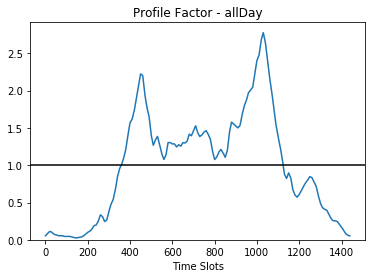

In [629]:
''' plot profile - profile of trips for this time of day period '''
plotTimeOfDayProfile(profile, timeOfDayString)


                 - Example orig/dest trip count series -
Synthesized trip counts for single TAZ pair [ 361 , 360 ] ingested profile:
[0 1 0 ..., 0 0 0]

countTable dtype: int16
non-zero OD pair index: 4073
2953 trips synthesized, 2864 projected



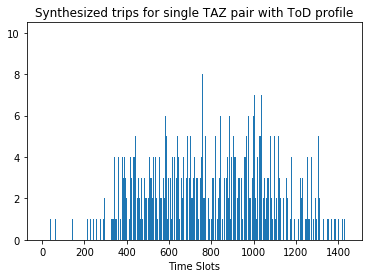

In [630]:
''' OD pair example - trips from a single origin/destination TAZ pair '''
showTimeOfDayExample(tripTable, countTable, numSlots, scaleFactor)

In [631]:
''' tripset file - save the trip set '''
saveTripSet(tripSet, fileDir, tripSetFileName)

Saving ...
trip_set_test_all_day.csv
Total trips in trip set: 3,821,719
Seconds to save tripSet: 26.04


In [632]:
''' shape file - read back tripset file and save shape file of TAZ boundaries, centroids and diffused origins '''
if saveShapeFile and not testRandom:
    originGdf, destinationGdf = readBackTripset(fileDir, tripSetFileName)
    saveToShapeFile(tazAreaGdf, centroidGdf, originGdf, destinationGdf, shapeFileDir)

In [633]:
'''time stats '''
totalTime = time.time()-mainTime
print('Seconds running main execution flow without diffusion:', '{:5.2f}'.format(totalTime-diffusionRunTime))
print('Seconds running the diffusion of OD locations:', '{:5.2f}'.format(diffusionRunTime))
print('Seconds running total main execution flow:', '{:5.2f}'.format(totalTime))

Seconds running main execution flow without diffusion: 34.08
Seconds running the diffusion of OD locations: 111.85
Seconds running total main execution flow: 145.93


<a id="section_end"></a>
#### &nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [&#8679;](#section_mef)&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; [top](#section_top)
